# Flower tutorial
## Introduction to federated learning

In this notebook, we’ll build a federated learning system using Flower and PyTorch. In part 1, we use PyTorch for the model training pipeline and data loading. In part 2, we continue to federate the PyTorch-based pipeline using Flower.

[tutorial link](https://flower.dev/docs/tutorial/Flower-1-Intro-to-FL-PyTorch.html)


## Client and NumPyClient

In this part of the tutorial, we see how we can build clients by subclassing either NumPyClient or Client. NumPyClient is a convenience abstraction that makes it easier to work with machine learning libraries that have good NumPy interoperability. Client is a more flexible abstraction that allows us to do things that are not possible in NumPyClient. In order to do so, it requires us to handle parameter serialization and deserialization ourselves.


[tutorial link](https://flower.dev/docs/tutorial/Flower-4-Client-and-NumPyClient-PyTorch.html)

## Installing flower

This does not work as described in the tutorial, at least not on one of the newer M1/M2 chips. Instead do the following:

* Create conda environment with python 3.10

  `conda create -n flower python=3.10`
  `conda activate flower`
* Install flower

  `pip install -U flwr-nightly["simulation"]`
* Install pytorch and matplotlib 

  `pip install -U torch torchvision matplotlib`
* Uninstall `grpcio` and re-install from `conda-forge` See [link](https://docs.ray.io/en/master/ray-overview/installation.html#m1-mac-apple-silicon-support). This is needed for M1/M2 chips.

  `pip uninstall grpcio; conda install grpcio=1.43.0 -c conda-forge`
* Install `ray`

  `pip install ray`

  
 


In [1]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

import flwr as fl
from flwr.common import Metrics

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.0.0 and Flower 1.5.0.dev20230427


In [2]:
CLASSES = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

In [3]:
NUM_CLIENTS = 10

In [4]:
BATCH_SIZE = 32


def load_datasets():
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

Files already downloaded and verified
Files already downloaded and verified


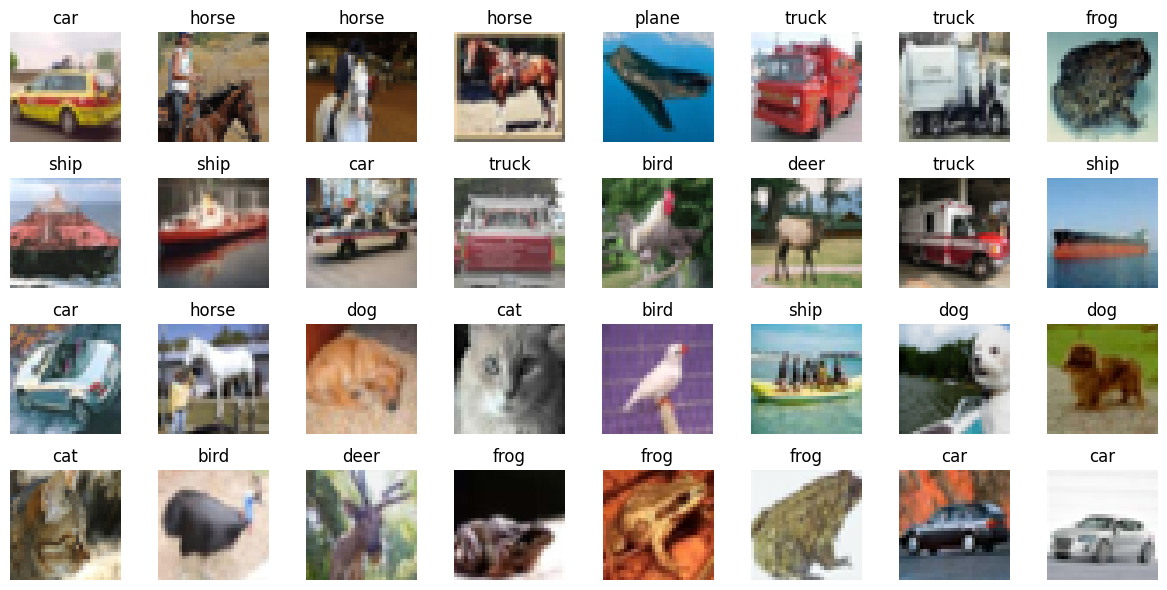

In [5]:
images, labels = next(iter(trainloaders[0]))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

In [6]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x





def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy



In [7]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: train loss 0.06407751142978668, accuracy 0.2368888888888889
Epoch 1: validation loss 0.06156213688850403, accuracy 0.246
Epoch 1: train loss 0.05637654289603233, accuracy 0.3393333333333333
Epoch 2: validation loss 0.05759164595603943, accuracy 0.318
Epoch 1: train loss 0.053131986409425735, accuracy 0.3768888888888889
Epoch 3: validation loss 0.05416042590141296, accuracy 0.384
Epoch 1: train loss 0.050676848739385605, accuracy 0.41333333333333333
Epoch 4: validation loss 0.05421305894851684, accuracy 0.374
Epoch 1: train loss 0.04868941754102707, accuracy 0.4371111111111111
Epoch 5: validation loss 0.05283419990539551, accuracy 0.386
Final test set performance:
	loss 0.04925286992788315
	accuracy 0.4156


# Step 2: Federated Learning with Flower

## Updating model parameters

We use state_dict to access PyTorch model parameter tensors. The parameter tensors are then converted to/from a list of NumPy ndarray’s (which Flower knows how to serialize/deserialize)


In [8]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

# Implementing a Flower client

Federated learning systems consist of a server and multiple clients. In Flower, we create clients by implementing subclasses of flwr.client.Client or flwr.client.NumPyClient. We use NumPyClient in this tutorial because it is easier to implement and requires us to write less boilerplate.

To implement the Flower client, we create a subclass of flwr.client.NumPyClient and implement the three methods get_parameters, fit, and evaluate:

* get_parameters: Return the current local model parameters

* fit: Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server

* evaluate: Receive model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server.

Let’s see a simple Flower client implementation that brings everything together:

In [9]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

Our class FlowerClient defines how local training/evaluation will be performed and allows Flower to call the local training/evaluation through fit and evaluate. Each instance of FlowerClient represents a single client in our federated learning system. Federated learning systems have multiple clients (otherwise, there’s not much to federate), so each client will be represented by its own instance of FlowerClient. If we have, for example, three clients in our workload, then we’d have three instances of FlowerClient. Flower calls FlowerClient.fit on the respective instance when the server selects a particular client for training (and FlowerClient.evaluate for evaluation).

## Using the Virtual Client Engine
In this notebook, we want to simulate a federated learning system with 10 clients on a single machine. This means that the server and all 10 clients will live on a single machine and share resources such as CPU, GPU, and memory. Having 10 clients would mean having 10 instances of FlowerClient in memory. Doing this on a single machine can quickly exhaust the available memory resources, even if only a subset of these clients participates in a single round of federated learning.

In addition to the regular capabilities where server and clients run on multiple machines, Flower, therefore, provides special simulation capabilities that create FlowerClient instances only when they are actually necessary for training or evaluation. To enable the Flower framework to create clients when necessary, we need to implement a function called client_fn that creates a FlowerClient instance on demand. Flower calls client_fn whenever it needs an instance of one particular client to call fit or evaluate (those instances are usually discarded after use, so they should not keep any local state). Clients are identified by a client ID, or short cid. The cid can be used, for example, to load different local data partitions for different clients, as can be seen below:

In [10]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

# Starting the training
We now have the class FlowerClient which defines client-side training/evaluation and client_fn which allows Flower to create FlowerClient instances whenever it needs to call fit or evaluate on one particular client. The last step is to start the actual simulation using flwr.simulation.start_simulation.

The function start_simulation accepts a number of arguments, amongst them the client_fn used to create FlowerClient instances, the number of clients to simulate (num_clients), the number of federated learning rounds (num_rounds), and the strategy. The strategy encapsulates the federated learning approach/algorithm, for example, Federated Averaging (FedAvg).

Flower has a number of built-in strategies, but we can also use our own strategy implementations to customize nearly all aspects of the federated learning approach. For this example, we use the built-in FedAvg implementation and customize it using a few basic parameters. The last step is the actual call to start_simulation which - you guessed it - starts the simulation:

In [11]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-05-23 11:42:47,415 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-05-23 11:42:49,129	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-05-23 11:42:49,737 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'memory': 7731493274.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0}
INFO flwr 2023-05-23 11:42:49,737 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-23 11:42:49,738 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-05-23 11:42:50,900 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-05-23 11:42:50,901 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-23 11:42:50,901 | server.py:101 | FL starting
DEBUG flwr 2023-05-23 11:42:50,901 | server.py:218 | fit_round 1: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=7069) Epoch 1: train loss 0.06448247283697128, accuracy 0.23933333333333334


DEBUG flwr 2023-05-23 11:42:59,962 | server.py:232 | fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-05-23 11:42:59,974 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-23 11:42:59,974 | server.py:168 | evaluate_round 1: strategy sampled 5 clients (out of 10)
DEBUG flwr 2023-05-23 11:43:02,800 | server.py:182 | evaluate_round 1 received 5 results and 0 failures
WARNING flwr 2023-05-23 11:43:02,800 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-05-23 11:43:02,800 | server.py:218 | fit_round 2: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=7071) Epoch 1: train loss 0.06543448567390442, accuracy 0.22355555555555556 [repeated 6x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(launch_and_fit pid=7070) Epoch 1: train loss 0.05736818537116051, accuracy 0.32711111111111113 [repeated 4x across cluster]


DEBUG flwr 2023-05-23 11:43:10,745 | server.py:232 | fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-05-23 11:43:10,753 | server.py:168 | evaluate_round 2: strategy sampled 5 clients (out of 10)
DEBUG flwr 2023-05-23 11:43:13,641 | server.py:182 | evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-05-23 11:43:13,642 | server.py:218 | fit_round 3: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=7073) Epoch 1: train loss 0.05298703536391258, accuracy 0.37555555555555553 [repeated 10x across cluster]


DEBUG flwr 2023-05-23 11:43:22,498 | server.py:232 | fit_round 3 received 10 results and 0 failures
DEBUG flwr 2023-05-23 11:43:22,507 | server.py:168 | evaluate_round 3: strategy sampled 5 clients (out of 10)
DEBUG flwr 2023-05-23 11:43:25,216 | server.py:182 | evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2023-05-23 11:43:25,216 | server.py:218 | fit_round 4: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=7069) Epoch 1: train loss 0.05021165683865547, accuracy 0.42 [repeated 10x across cluster]


DEBUG flwr 2023-05-23 11:43:32,929 | server.py:232 | fit_round 4 received 10 results and 0 failures
DEBUG flwr 2023-05-23 11:43:32,937 | server.py:168 | evaluate_round 4: strategy sampled 5 clients (out of 10)
DEBUG flwr 2023-05-23 11:43:35,701 | server.py:182 | evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2023-05-23 11:43:35,701 | server.py:218 | fit_round 5: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=7067) Epoch 1: train loss 0.04879522696137428, accuracy 0.43022222222222223 [repeated 10x across cluster]


DEBUG flwr 2023-05-23 11:43:44,001 | server.py:232 | fit_round 5 received 10 results and 0 failures
DEBUG flwr 2023-05-23 11:43:44,010 | server.py:168 | evaluate_round 5: strategy sampled 5 clients (out of 10)
DEBUG flwr 2023-05-23 11:43:46,879 | server.py:182 | evaluate_round 5 received 5 results and 0 failures
INFO flwr 2023-05-23 11:43:46,880 | server.py:147 | FL finished in 55.97960208298173
INFO flwr 2023-05-23 11:43:46,880 | app.py:218 | app_fit: losses_distributed [(1, 0.06215694012641907), (2, 0.05428751530647278), (3, 0.051154690694808956), (4, 0.04925553979873657), (5, 0.04878005490303039)]
INFO flwr 2023-05-23 11:43:46,881 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-05-23 11:43:46,881 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-05-23 11:43:46,881 | app.py:221 | app_fit: losses_centralized []
INFO flwr 2023-05-23 11:43:46,881 | app.py:222 | app_fit: metrics_centralized {}


History (loss, distributed):
	round 1: 0.06215694012641907
	round 2: 0.05428751530647278
	round 3: 0.051154690694808956
	round 4: 0.04925553979873657
	round 5: 0.04878005490303039

# Behind the scenes
So how does this work? How does Flower execute this simulation?

When we call start_simulation, we tell Flower that there are 10 clients (num_clients=10). Flower then goes ahead an asks the FedAvg strategy to select clients. FedAvg knows that it should select 100% of the available clients (fraction_fit=1.0), so it goes ahead and selects 10 random clients (i.e., 100% of 10).

Flower then asks the selected 10 clients to train the model. When the server receives the model parameter updates from the clients, it hands those updates over to the strategy (FedAvg) for aggregation. The strategy aggregates those updates and returns the new global model, which then gets used in the next round of federated learning.

# Where’s the accuracy?
You may have noticed that all metrics except for losses_distributed are empty. Where did the {"accuracy": float(accuracy)} go?

Flower can automatically aggregate losses returned by individual clients, but it cannot do the same for metrics in the generic metrics dictionary (the one with the accuracy key). Metrics dictionaries can contain very different kinds of metrics and even key/value pairs that are not metrics at all, so the framework does not (and can not) know how to handle these automatically.

As users, we need to tell the framework how to handle/aggregate these custom metrics, and we do so by passing metric aggregation functions to the strategy. The strategy will then call these functions whenever it receives fit or evaluate metrics from clients. The two possible functions are fit_metrics_aggregation_fn and evaluate_metrics_aggregation_fn.

Let’s create a simple weighted averaging function to aggregate the accuracy metric we return from evaluate:



In [12]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

The only thing left to do is to tell the strategy to call this function whenever it receives evaluation metric dictionaries from the clients:



In [13]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-05-23 12:35:23,494 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)


(launch_and_fit pid=7072) Epoch 1: train loss 0.050093892961740494, accuracy 0.4131111111111111 [repeated 9x across cluster]


2023-05-23 12:35:27,739	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-05-23 12:35:28,414 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 6630114919.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0}
INFO flwr 2023-05-23 12:35:28,414 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-23 12:35:28,414 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-05-23 12:35:29,910 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-05-23 12:35:29,910 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-23 12:35:29,910 | server.py:101 | FL starting
DEBUG flwr 2023-05-23 12:35:29,911 | server.py:218 | fit_round 1: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=7390) Epoch 1: train loss 0.06541229039430618, accuracy 0.21711111111111112


DEBUG flwr 2023-05-23 12:35:39,279 | server.py:232 | fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-05-23 12:35:39,288 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-23 12:35:39,288 | server.py:168 | evaluate_round 1: strategy sampled 5 clients (out of 10)
DEBUG flwr 2023-05-23 12:35:42,098 | server.py:182 | evaluate_round 1 received 5 results and 0 failures
DEBUG flwr 2023-05-23 12:35:42,099 | server.py:218 | fit_round 2: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=7387) Epoch 1: train loss 0.0652557909488678, accuracy 0.2137777777777778 [repeated 8x across cluster]
(launch_and_fit pid=7388) Epoch 1: train loss 0.05958586931228638, accuracy 0.3042222222222222 [repeated 2x across cluster]


DEBUG flwr 2023-05-23 12:35:50,348 | server.py:232 | fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-05-23 12:35:50,357 | server.py:168 | evaluate_round 2: strategy sampled 5 clients (out of 10)
DEBUG flwr 2023-05-23 12:35:53,133 | server.py:182 | evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-05-23 12:35:53,134 | server.py:218 | fit_round 3: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=7390) Epoch 1: train loss 0.05545122176408768, accuracy 0.3537777777777778 [repeated 10x across cluster]


DEBUG flwr 2023-05-23 12:36:01,548 | server.py:232 | fit_round 3 received 10 results and 0 failures
DEBUG flwr 2023-05-23 12:36:01,557 | server.py:168 | evaluate_round 3: strategy sampled 5 clients (out of 10)
DEBUG flwr 2023-05-23 12:36:04,451 | server.py:182 | evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2023-05-23 12:36:04,451 | server.py:218 | fit_round 4: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=7384) Epoch 1: train loss 0.05472414195537567, accuracy 0.362 [repeated 8x across cluster]
(launch_and_fit pid=7386) Epoch 1: train loss 0.05211970582604408, accuracy 0.38 [repeated 2x across cluster]


DEBUG flwr 2023-05-23 12:36:13,100 | server.py:232 | fit_round 4 received 10 results and 0 failures
DEBUG flwr 2023-05-23 12:36:13,111 | server.py:168 | evaluate_round 4: strategy sampled 5 clients (out of 10)
DEBUG flwr 2023-05-23 12:36:16,105 | server.py:182 | evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2023-05-23 12:36:16,106 | server.py:218 | fit_round 5: strategy sampled 10 clients (out of 10)


(launch_and_fit pid=7388) Epoch 1: train loss 0.05164716765284538, accuracy 0.3948888888888889 [repeated 10x across cluster]


DEBUG flwr 2023-05-23 12:36:24,239 | server.py:232 | fit_round 5 received 10 results and 0 failures
DEBUG flwr 2023-05-23 12:36:24,249 | server.py:168 | evaluate_round 5: strategy sampled 5 clients (out of 10)
DEBUG flwr 2023-05-23 12:36:27,194 | server.py:182 | evaluate_round 5 received 5 results and 0 failures
INFO flwr 2023-05-23 12:36:27,195 | server.py:147 | FL finished in 57.283965624985285
INFO flwr 2023-05-23 12:36:27,195 | app.py:218 | app_fit: losses_distributed [(1, 0.06434256653785705), (2, 0.05636266679763794), (3, 0.05337083358764648), (4, 0.05134624629020691), (5, 0.04950505838394165)]
INFO flwr 2023-05-23 12:36:27,195 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-05-23 12:36:27,196 | app.py:220 | app_fit: metrics_distributed {'accuracy': [(1, 0.23520000000000002), (2, 0.3564), (3, 0.3736), (4, 0.40800000000000003), (5, 0.43200000000000005)]}
INFO flwr 2023-05-23 12:36:27,196 | app.py:221 | app_fit: losses_centralized []
INFO flwr 2023-05-23 12:36:27,

History (loss, distributed):
	round 1: 0.06434256653785705
	round 2: 0.05636266679763794
	round 3: 0.05337083358764648
	round 4: 0.05134624629020691
	round 5: 0.04950505838394165
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.23520000000000002), (2, 0.3564), (3, 0.3736), (4, 0.40800000000000003), (5, 0.43200000000000005)]}

We now have a full system that performs federated training and federated evaluation. It uses the weighted_average function to aggregate custom evaluation metrics and calculates a single accuracy metric across all clients on the server side.

The other two categories of metrics (losses_centralized and metrics_centralized) are still empty because they only apply when centralized evaluation is being used. Part two of the Flower tutorial will cover centralized evaluation.